# Generative Adversarial Networks
GANs learn to generate new data with the same statistics as the training set.

GANs consists of 2 networks playing an adversarial game against each other. Those are: Generator and Discriminator.

## **Generator vs Discriminator**
- Generator produces fake data and tries to trick the Discriminator.
- Discriminator inspect the fake data and determines if it's real or fake.

Generator and Discriminator are randomly initialized in the beginning and are then trained simultaneously...
It means we need to minimize the 2 losses (i.e. 2 optimizer) -> We will use the Binary Cross Entropy.


In [35]:
!pip install pytorch-lightning

In [36]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from   torch.utils.data import DataLoader, random_split
from   torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import pytorch_lightning as pl

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE = 128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)

In [37]:
class MNISTDataModule(pl.LightningDataModule):

  def __init__(self, data_dir = './data', batch_size = BATCH_SIZE, num_workers = NUM_WORKERS):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size
    self.num_workers = num_workers

    self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

  def prepare_data(self):
    MNIST(self.data_dir, train = True, download = True)
    MNIST(self.data_dir, train = False, download = True)

  def setup(self, stage = None):
    # Assign train/val datasets
    if stage == 'fit' or stage is None:
      mnist_full = MNIST(self.data_dir, train = True, transform = self.transform)
      self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
    # Assign test datasets
    if stage == 'test' or stage is None:
      self.mnist_test = MNIST(self.data_dir, train = False, transform = self.transform)

  def train_dataloader(self):
    return DataLoader(self.mnist_train, batch_size = self.batch_size, num_workers = self.num_workers)

  def val_dataloader(self):
    return DataLoader(self.mnist_val, batch_size = self.batch_size, num_workers = self.num_workers)

  def test_dataloader(self):
    return DataLoader(self.mnist_test, batch_size = self.batch_size, num_workers = self.num_workers)

In [38]:
# =============================== DISCRMINATOR ===============================
# Detective: Fake or No-Fake -> 1 output [0, 1]
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()
    # Simple CNN
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 10, kernel_size = 5)
    self.conv2d_drop = nn.Dropout2d()
    self.fullyconnected1 = nn.Linear(320, 50)
    self.fullyconnected2 = nn.Linear(50, 1)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2d_drop(self.conv2(x)), 2))
    # Flatten the tensor so it can be fed into the FC layers
    x = x.view(-1, 320)
    x = F.relu(self.fullyconnected1(x))
    x = F.dropout(x, training = self.training)
    x = self.fullyconnected2(x)
    return torch.sigmoid(x)

In [39]:
# =============================== GENERATOR ===============================
# Generate Fake Data: Output like real data [1, 28, 28] and values [-1, 1]
class Generator(nn.Module):

  def __init__(self, latent_dim):
    super().__init__()
    self.linear1 = nn.Linear(latent_dim, 7*7*64) # [n, 256, 7, 7]
    self.convolutionalTranspose1 = nn.ConvTranspose2d(64, 32, 4, stride = 2) # [n, 64, 16, 16]
    self.convolutionalTranspose2 = nn.ConvTranspose2d(32, 16, 4, stride = 2) # [n, 16, 34, 34]
    self.conv = nn.Conv2d(16, 1, kernel_size = 7) # [n, 1, 28, 28]

  def forward(self, x):
    # Pass latent space input into linear layer and reshape
    x = self.linear1(x)
    x = F.relu(x)
    x = x.view(-1, 64, 7, 7) # 256

    # Upsample (transposed conv) 16x16 (64 features maps)
    x = self.convolutionalTranspose1(x)
    x = F.relu(x)

    # Upsample to 34x34 (16 features maps)
    x = self.convolutionalTranspose2(x)
    x = F.relu(x)

    # Convolution to 28x28 (1 feature map)
    return self.conv(x)

In [57]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class GenerativeAdversarialNetwork(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.automatic_optimization = False
        self.save_hyperparameters()

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        self.validation_z = torch.randn(6, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch
        batch_size = real_imgs.size(0)
        opt_g, opt_d = self.optimizers()

        # -----------------
        #  Train Generator
        # -----------------
        opt_g.zero_grad()
        z = torch.randn(batch_size, self.hparams.latent_dim, device=self.device)
        fake_imgs = self(z)
        preds = self.discriminator(fake_imgs)
        valid = torch.ones_like(preds, device=self.device)
        g_loss = self.adversarial_loss(preds, valid)
        self.manual_backward(g_loss)
        opt_g.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        opt_d.zero_grad()
        real_preds = self.discriminator(real_imgs)
        valid = torch.ones_like(real_preds, device=self.device)
        real_loss = self.adversarial_loss(real_preds, valid)

        fake_imgs_detached = fake_imgs.detach()
        fake_preds = self.discriminator(fake_imgs_detached)
        fake = torch.zeros_like(fake_preds, device=self.device)
        fake_loss = self.adversarial_loss(fake_preds, fake)
        d_loss = (real_loss + fake_loss) / 2
        self.manual_backward(d_loss)
        opt_d.step()

        self.log("g_loss", g_loss, prog_bar=True, logger=True)
        self.log("d_loss", d_loss, prog_bar=True, logger=True)
        return {"g_loss": g_loss, "d_loss": d_loss}

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d]

    def plot_images(self):
        z = self.validation_z.to(self.device)
        sample_imgs = self(z).cpu()
        print('Epoch:', self.current_epoch)
        fig = plt.figure(figsize=(6, 4))
        for i in range(sample_imgs.size(0)):
            ax = fig.add_subplot(2, 3, i + 1)
            ax.imshow(sample_imgs[i, 0, :, :].detach(), cmap='gray_r', interpolation='none')
            ax.axis('off')
        plt.show()

    def on_epoch_end(self):
        self.plot_images()

We are just printing the Noise
Epoch: 0


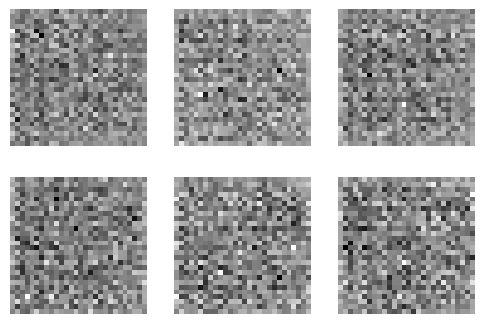

In [58]:
data_module = MNISTDataModule()
model = GenerativeAdversarialNetwork()
print("We are just printing the Noise")
model.plot_images()

In [59]:
trainer = pl.Trainer(max_epochs = 20, accelerator = 'gpu')

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [60]:
# fit the model
trainer.fit(model, data_module)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 18.9 K | train
--------------------------------------------------------
377 K     Trainable params
0         Non-trainable params
377 K     Total params
1.510     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


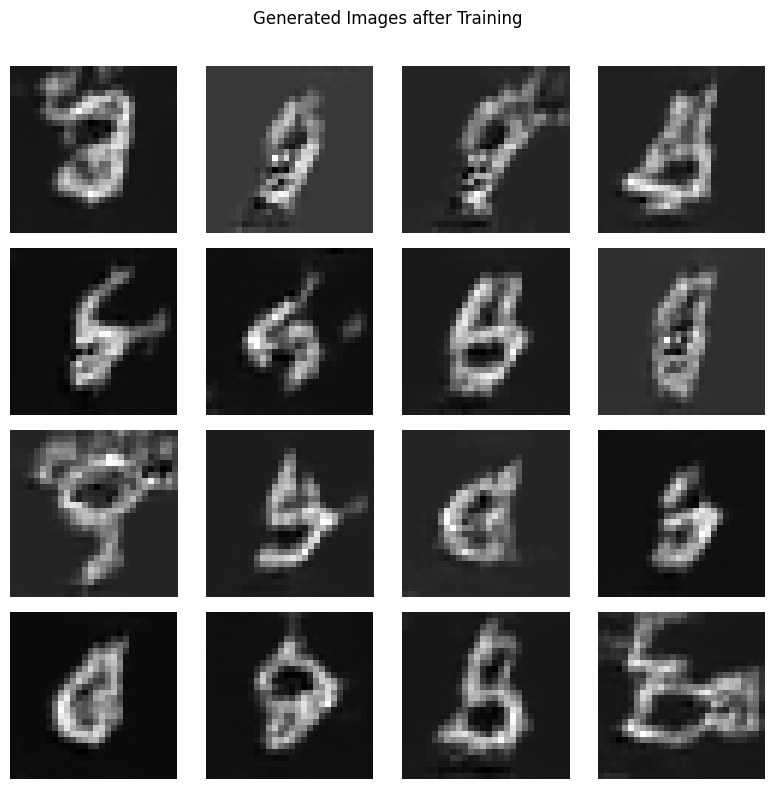

In [62]:
# Generate a batch of images from the trained generator
z = torch.randn(16, model.hparams.latent_dim, device=model.device)
fake_images = model(z).detach().cpu()

# Normalize images to be in the range [0, 1] for plotting
fake_images = (fake_images + 1) / 2

# Plot the generated images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(fake_images[i, 0, :, :], cmap='gray')
    ax.axis('off')

plt.suptitle("Generated Images after Training")
plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to make space for title
plt.show()